# Lecture 02
 
Code for making illustrations for lecture 2. As mentioned in the lecture,  linear regression is used for illustrating optimization this year. The methods below are not necessarily the best ones for estimating the model parameters.

In [1]:
import numpy as np
from scipy.optimize import minimize
import io
import cv2
from tqdm import tqdm
from multiprocessing import Pool
import os

import matplotlib.pyplot as plt

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with differe

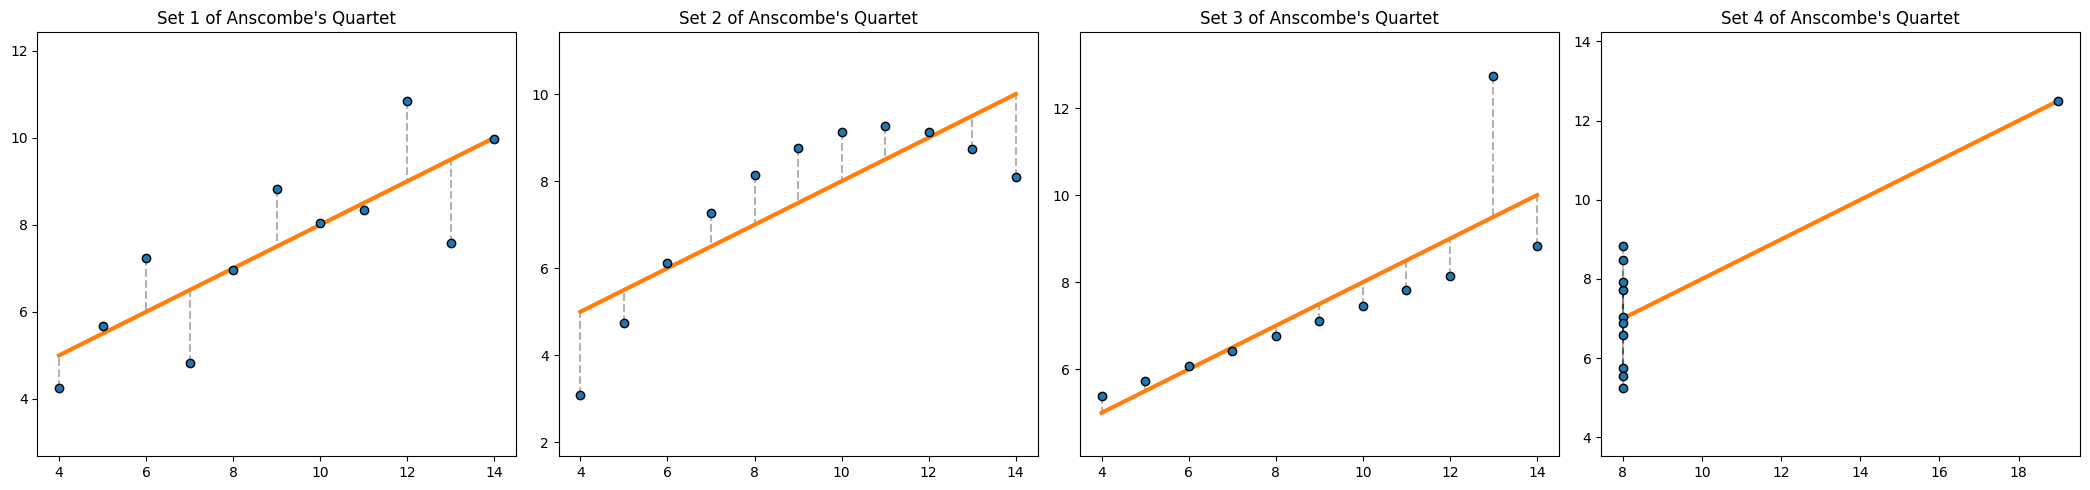

In [2]:
# Anscombe's Quartet
def anscombe(n=1):
  assert 1 <= n and n <= 4
  X = np.vstack([10, 8, 13, 9, 11, 14, 6, 4, 12, 7, 5])
  if n == 1:
    y = [8.04, 6.95, 7.58, 8.81, 8.33, 9.96, 7.24, 4.26, 10.84, 4.82, 5.68]
  elif n == 2:
    y = [9.14, 8.14, 8.74, 8.77, 9.26, 8.10, 6.13, 3.10, 9.13, 7.26, 4.74]
  elif n == 3:
    y = [7.46, 6.77, 12.74, 7.11, 7.81, 8.84, 6.08, 5.39, 8.15, 6.42, 5.73]
  elif n == 4:
    X = [8, 8, 8, 8, 8, 8, 8, 19, 8, 8, 8]
    y = [6.58, 5.76, 7.71, 8.84, 8.47, 7.04, 5.25, 12.50, 5.56, 7.91, 6.89]
  X = np.vstack(X)
  y = np.asarray(y)
  return X, y


def poly_model(x, theta):
  model_order = len(theta)-1
  ret = np.ones(x.shape)*theta[0]   # Constant part
  for n in range(1, model_order+1):       # Sum over degrees of x^n
    ret += (x**n)*theta[n]
  return ret.ravel()


def plot_residuals(X, y, model=None, ax=None):
  if ax is None:
    fig = plt.figure(figsize=(5, 5), dpi=100)
    ax = fig.subplots(1, 1)
  if model is not None:
    x_plot = np.linspace(X.min(), X.max(), 50)
    ax.plot(x_plot, model(x_plot), color='C1', linewidth=3, zorder=0)
    for j in range(X.shape[0]):
      ax.plot([X[j], X[j]], [y[j], model(X[j])], 
                'k--', alpha=.3, zorder=-1)
  ax.scatter(X, y, color='C0', edgecolors='k', zorder=1)
  ax.axis('equal')
  if ax is None:
    fig.show()


fig = plt.figure(figsize=(4*5+1, 5), dpi=100)
ax = fig.subplots(1, 4)
for i in range(4):
  X, y = anscombe(i+1)
  plot_residuals(X, y, lambda X: poly_model(X, [3, .5]), ax[i])
  ax[i].set_title("Set %i of Anscombe's Quartet" % (i+1))
fig.tight_layout()
fig.show()

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


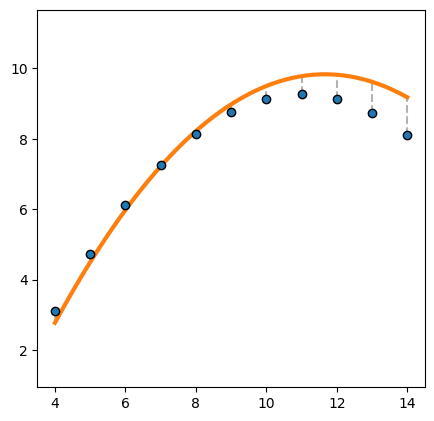

In [3]:
X, y = anscombe(2)
# plot_residuals(X, y, lambda X: poly_model(X, [-6.5,  2.8, -0.12]))
plot_residuals(X, y, lambda X: poly_model(X, [-6.5,  2.8, -0.12]))

In [4]:
def plot_wrapper(theta):
  fig = plt.figure(figsize=(5, 5), dpi=100)
  ax = fig.subplots(1, 1)
  plot_residuals(X, y, lambda X: poly_model(X, theta), ax)
  ax.text(7, 2, "Theta: [%.3f, %.3f, %.3f]" % tuple(theta))
  fig.tight_layout()
  return fig


def image_from_figure(fig, dpi=100):
  buffer = io.BytesIO()
  fig.savefig(buffer, format="png", dpi=dpi)
  buffer.seek(0)
  raw = np.frombuffer(buffer.getvalue(), dtype=np.uint8)
  buffer.close()
  image = cv2.imdecode(raw, 1)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  return image


def render_frame(theta):
  fig = plot_wrapper(theta)
  image = image_from_figure(fig)
  plt.close(fig)
  return image


from scipy.optimize import minimize
path = [np.asarray([2, 0, 0])]
loss = lambda theta: np.sum((poly_model(X, theta)-y)**2)
def store_theta_during_optimization(current_theta):
  path.append(current_theta)
res = minimize(loss, path[0], callback=store_theta_during_optimization)

path = np.concatenate([np.vstack(h).T for h in path])
n_frames = 50
interpolated_path = np.zeros((n_frames, path.shape[1]))
for i in range(interpolated_path.shape[1]):
  interpolated_path[:, i] = np.interp(np.linspace(0, 1, num=n_frames), 
                                      np.linspace(0, 1, num=path.shape[0]), 
                                      path[:, i].ravel())

# Render frames
fourcc = cv2.VideoWriter_fourcc(*'MP4V')
test_image = render_frame([3, .5, 0])
video = cv2.VideoWriter('poly_model.mp4', fourcc, 10, (test_image.shape[0], test_image.shape[1]))
for i, image in tqdm(enumerate(map(render_frame, [point.ravel() for point in interpolated_path])), 
                     total=interpolated_path.shape[0], desc="Rendering frames"):
  video.write(image)
video.release()


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
Rendering frames:   0%|          | 0/50 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
Rendering frames:   2%|▏         | 1/50 [00:00<00:07,  6.90it/s]/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning

In [5]:
!ls -l

total 360
-rw-r--r-- 1 root root 361102 Mar 17 13:14 poly_model.mp4
drwxr-xr-x 1 root root   4096 Mar  5 14:37 sample_data


A series with order $N$:

$s_{N}(x)={\frac {\theta_{1}}{2}}+\sum _{n=1}^{N}\left(\theta_{2n}\cos \left({\tfrac {2\pi nx}{\theta_0}}\right)+\theta_{2n+1}\sin \left({\tfrac {2\pi nx}{\theta_0}}\right)\right)$

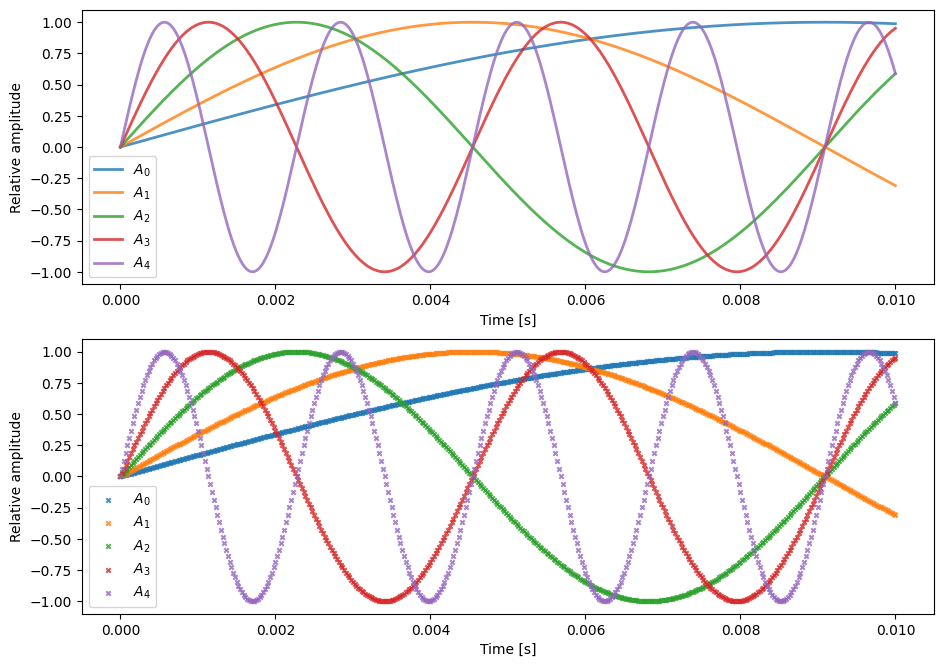

In [7]:
freq_of_A = lambda octave: 440*2**(octave-4)

fig = plt.figure(figsize=(11, 8), dpi=100)
ax = fig.subplots(2, 1)
t = np.linspace(0, .01, 400)
s = np.linspace(t.min(), t.max(), int(44100*(t.max()-t.min())))
for octave in range(5):
  ax[0].plot(t, np.sin(t*2*np.pi*freq_of_A(octave)), linewidth=2, label="$A_%i$" % octave, alpha=.8)
  ax[1].scatter(s, np.sin(s*2*np.pi*freq_of_A(octave)), s=10, marker='x', label="$A_%i$" % octave, alpha=.8)
for i in range(2):
  ax[i].legend()
  ax[i].set_ylabel("Relative amplitude")
  ax[i].set_xlabel("Time [s]")
fig.show()

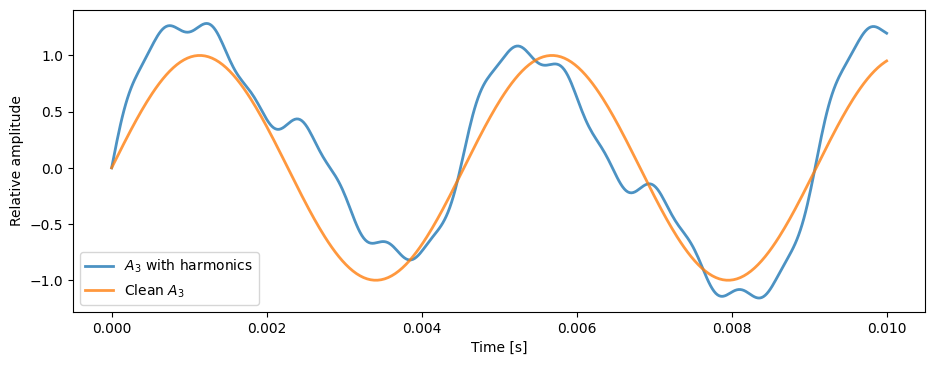

In [48]:
from scipy.stats import norm
freq_of_A = lambda octave: 440*2**(octave-4)

fig = plt.figure(figsize=(11, 4), dpi=100)
ax = fig.subplots(1, 1)
y = np.zeros(len(s))
y += np.sin(s*2*np.pi*freq_of_A(0))*.05
y += np.sin(s*2*np.pi*freq_of_A(1))*.1
y += np.sin(s*2*np.pi*freq_of_A(2))*.3
y += np.sin(s*2*np.pi*freq_of_A(3))
y += np.sin(s*2*np.pi*freq_of_A(4))*.3
y += np.sin(s*2*np.pi*freq_of_A(5))*.1
y += np.sin(s*2*np.pi*freq_of_A(6))*.05
ax.plot(s, y, linewidth=2, alpha=.8, label="$A_3$ with harmonics")
ax.plot(s, np.sin(s*2*np.pi*freq_of_A(3)), linewidth=2, alpha=.8, label="Clean $A_3$")
ax.legend()
ax.set_ylabel("Relative amplitude")
ax.set_xlabel("Time [s]")
fig.show()

In [49]:
n_octaves = 6
note_frequencies = np.exp(np.linspace(np.log(freq_of_A(0)), np.log(freq_of_A(n_octaves)), 12*n_octaves+1))

def simplified_fourier_series(x, theta):
  ret = 0
  for i in range(len(theta)):
    ret += theta[i]*np.sin(x*note_frequencies[i]*2*np.pi)
  return ret

X = s

theta0 = np.random.normal(0, .1, size=len(note_frequencies))
loss = lambda theta: np.sum((y - simplified_fourier_series(X, theta))**2)

res = minimize(loss, theta0, bounds=[(0, 1)]*len(theta0), options={'disp': True})
theta = res.x
res

      fun: 9.879589745111068e-05
 hess_inv: <73x73 LbfgsInvHessProduct with dtype=float64>
      jac: array([-6.65829416e-03, -6.65564788e-03, -6.59068661e-03, -6.45209875e-03,
       -6.22771405e-03, -5.90476906e-03, -5.47033004e-03, -4.91192938e-03,
       -4.21846436e-03, -3.38142220e-03, -2.39649188e-03, -1.26560231e-03,
        5.93786359e-07,  1.37984133e-03,  2.83516625e-03,  4.31182693e-03,
        5.73489450e-03,  7.00832504e-03,  8.01678257e-03,  8.63189260e-03,
        8.72491522e-03,  8.18783012e-03,  6.96414120e-03,  5.08875045e-03,
        2.73243101e-03,  2.40158341e-04, -1.85602829e-03, -2.87811246e-03,
       -2.13063702e-03,  8.58058232e-04,  5.99142980e-03,  1.22411502e-02,
        1.74624970e-02,  1.87040798e-02,  1.33460048e-02,  1.14963899e-03,
       -1.33835519e-02, -2.00027091e-02, -5.48899416e-03,  3.82253303e-02,
        1.03082896e-01,  1.59937219e-01,  1.71233195e-01,  1.22232334e-01,
        4.58973354e-02,  1.37521314e-03,  6.29733719e-03,  8.85855803e-03

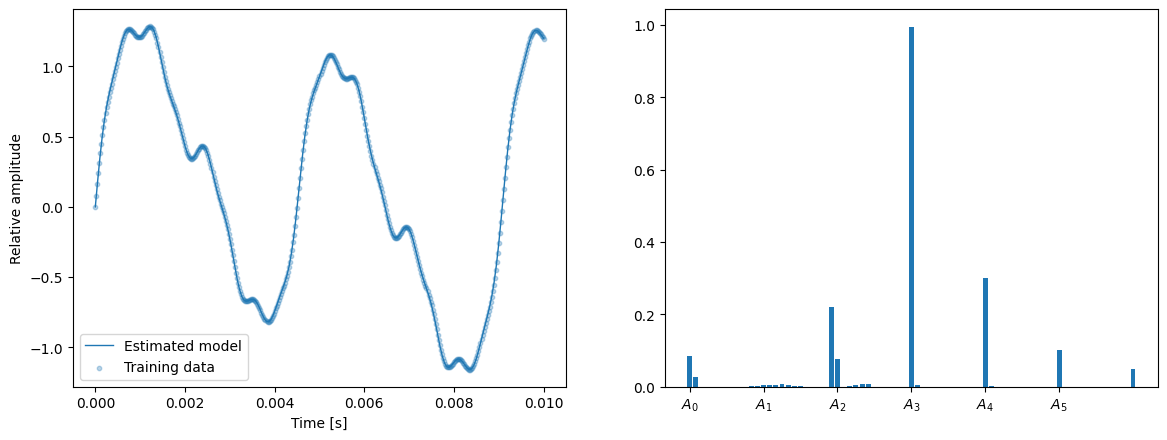

In [50]:
fig = plt.figure(figsize=(14, 5), dpi=100)
ax = fig.subplots(1, 2)

ax[0].scatter(X, y, color='C0', alpha=.3, s=10, label="Training data")
X_plot = np.vstack(np.linspace(X.min(), X.max(), 200))
ax[0].plot(X_plot, simplified_fourier_series(X_plot, theta), color='C0', linewidth=1, label="Estimated model")
ax[0].legend()
ax[0].set_ylabel("Relative amplitude")
ax[0].set_xlabel("Time [s]")

ax[1].bar(np.arange(len(theta)), theta)#, width=.8, color=c)
ax[1].set_xticks([o*12 for o in range(6)])
ax[1].set_xticklabels(["$A_%i$" % o for o in range(6)])

fig.show()


Periodic function

Sawtooth wave: $f(x) = x - \lfloor x \rfloor$

Square wave: $f(x) = f(x) = \left\{\begin{matrix}
1 &, x - \lfloor x \rfloor \geq 0.5\\ 
0 &, x - \lfloor x \rfloor < 0.5
\end{matrix}\right.$

In [51]:
order = 3
period = 1
theta = np.ones(2 + order*2)
theta[0] = period

assert (len(theta) % 2) == 0 and len(theta) >= 2

def fourier_series(x, theta):
  ret = theta[1]/2
  for n in range(1, len(theta)//2):
    ret += theta[n*2]*np.cos(2*np.pi*n*x/theta[0]) + theta[n*2+1]*np.sin(2*np.pi*n*x/theta[0])
  return ret

fourier_series(np.vstack(np.linspace(0, 2, 5)), theta)

array([[ 3.5],
       [-0.5],
       [ 3.5],
       [-0.5],
       [ 3.5]])

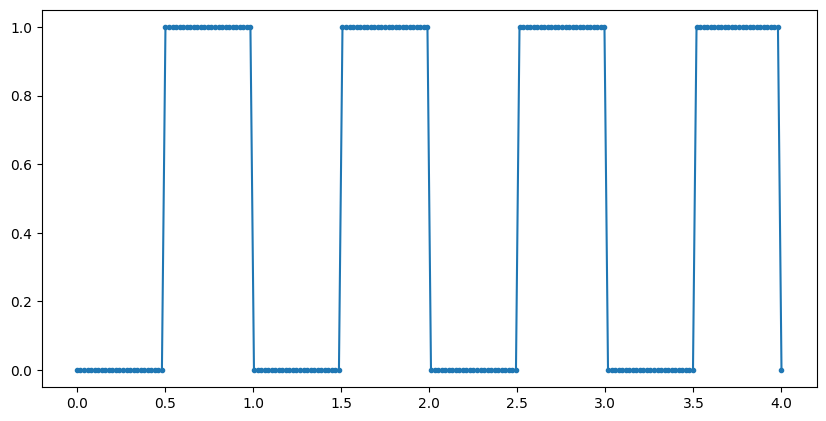

In [61]:
sawtooth = lambda x: x - np.floor(x)
square = lambda x: np.asarray((x - np.floor(x)) >= .5, dtype=np.float)
# f = sawtooth
f = square

X_plot = np.vstack(np.linspace(0, 4, 200))
y = f(X_plot)

plt.figure(figsize=(10, 5), dpi=100)
plt.plot(X_plot.ravel(), y.ravel(), '.-', color='C0')
plt.show()

Started at [ 1.          0.85630162 -1.8558001  -0.44721236  0.76017342  1.40908454
 -1.79289029 -1.62346577  0.66555147 -1.42214057  1.19271102  1.22043105
 -1.8778024   1.67316292 -1.10122757 -1.27685735  0.01589238 -1.79289941
  0.7924829  -1.96297523 -1.3084993   1.55331419], found minima at [ 9.99116814e-01  9.83536601e-01 -9.40342575e-03 -6.36765016e-01
 -1.64842177e-02  1.61946614e-04 -9.40847178e-03 -2.12637710e-01
 -1.65252506e-02  3.40882504e-04 -9.41262049e-03 -1.28035428e-01
 -1.65949980e-02  5.68317386e-04 -9.43134615e-03 -9.19214731e-02
 -1.67164766e-02  8.65444931e-04 -9.47423425e-03 -7.19337538e-02
 -1.69151896e-02  1.28734124e-03]
Objective function value: 1.086


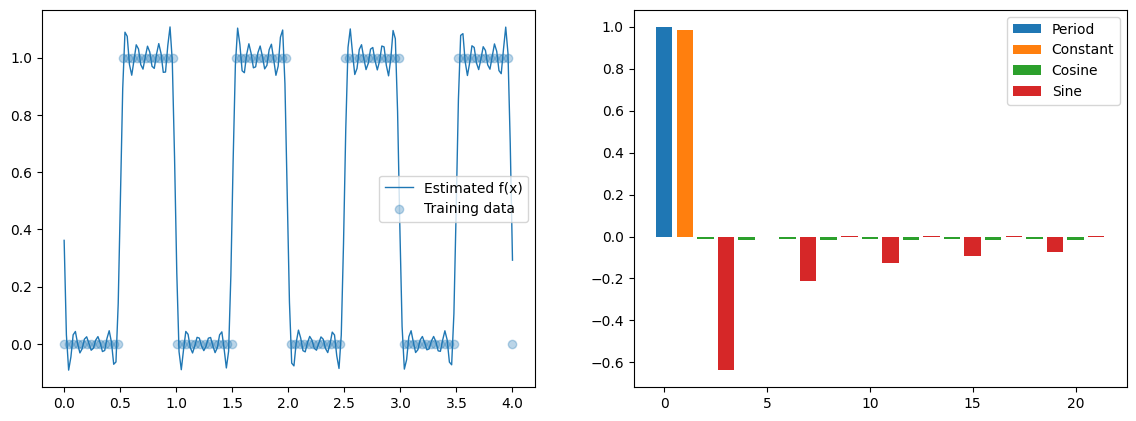

In [65]:
model_order = 10
n_data = 100

X = np.linspace(0, 4, n_data)
y = square(X)

loss = lambda theta: np.sum((y - fourier_series(X, theta))**2)
theta0 = np.random.uniform(-2, 2, size=2+2*model_order)
theta0[0] = 1

#bounds = [(-2, 2)]*len(theta0)
bounds = [(None, None)]*len(theta0)
#bounds[0] = (.9, 1.1)

res = minimize(loss, theta0, bounds=bounds, options={'disp': True})
theta = res.x
print("Started at %s, found minima at %s" % (theta0, theta))
print("Objective function value: %.3f" % res.fun)

fig = plt.figure(figsize=(14, 5), dpi=100)
ax = fig.subplots(1, 2)

ax[0].scatter(X, y, color='C0', alpha=.3, label="Training data")
X_plot = np.vstack(np.linspace(X.min(), X.max(), 200))
ax[0].plot(X_plot, fourier_series(X_plot, theta), color='C0', linewidth=1, label="Estimated f(x)")
ax[0].legend()

b = list(range(len(theta)))
ax[1].bar(b[0], theta[0], width=.8, color='C0', label="Period")
ax[1].bar(b[1], theta[1], width=.8, color='C1', label="Constant")
ax[1].bar(b[2], theta[2], width=.8, color='C2', label="Cosine")
ax[1].bar(b[3], theta[3], width=.8, color='C3', label="Sine")
for i in range(4, len(theta0)):
  if (i % 2) == 0:
    c = 'C2'
  else:
    c = 'C3'
  ax[1].bar(b[i], theta[i], width=.8, color=c)
ax[1].legend()

fig.show()

Started at [ 1.         -0.20763505  0.37391057  0.36639867  1.12934518  0.2926441
  1.64774466 -0.88222163  0.12612721  1.70724079 -0.95788601  0.94856392
  1.54191816  1.85630868  0.96071411 -1.34326151 -1.25596448 -0.11977164
 -1.97105031  1.47503417  1.71652169 -0.52489517], found minima at [ 1.00213942  0.98275882 -0.02577622 -0.31824386 -0.02570724 -0.1580142
 -0.02559384 -0.10413242 -0.02544091 -0.07685255 -0.02524267 -0.06024291
 -0.02500175 -0.04898482 -0.02472264 -0.04082791 -0.0244117  -0.03463981
 -0.02407533 -0.02981155 -0.02371425 -0.02599089]
Objective function value: 0.566


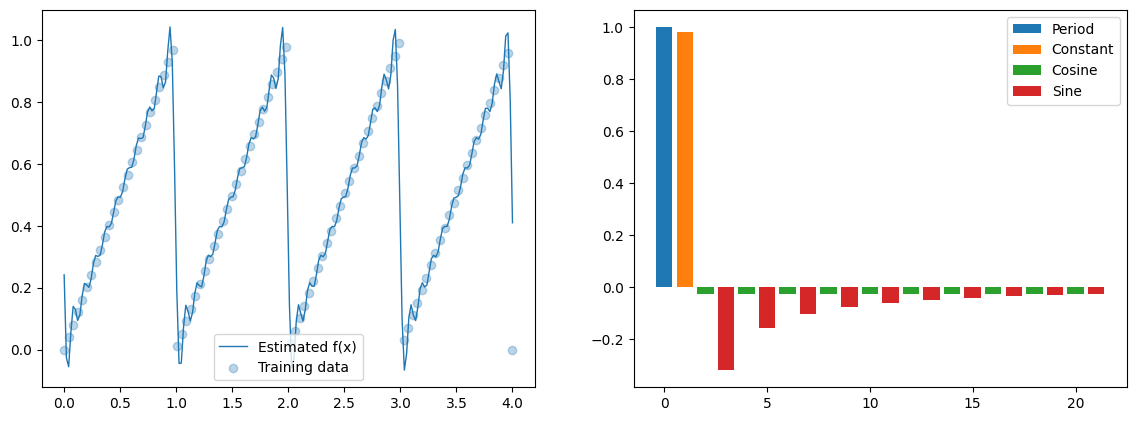

In [70]:
model_order = 10
n_data = 100

X = np.linspace(0, 4, n_data)
y = sawtooth(X)

loss = lambda theta: np.sum((y - fourier_series(X, theta))**2)
theta0 = np.random.uniform(-2, 2, size=2+2*model_order)
theta0[0] = 1

#bounds = [(-2, 2)]*len(theta0)
bounds = [(None, None)]*len(theta0)
#bounds[0] = (.9, 1.1)

res = minimize(loss, theta0, bounds=bounds, options={'disp': True})
theta = res.x
print("Started at %s, found minima at %s" % (theta0, theta))
print("Objective function value: %.3f" % res.fun)

fig = plt.figure(figsize=(14, 5), dpi=100)
ax = fig.subplots(1, 2)

ax[0].scatter(X, y, color='C0', alpha=.3, label="Training data")
X_plot = np.vstack(np.linspace(X.min(), X.max(), 200))
ax[0].plot(X_plot, fourier_series(X_plot, theta), color='C0', linewidth=1, label="Estimated f(x)")
ax[0].legend()

b = list(range(len(theta)))
ax[1].bar(b[0], theta[0], width=.8, color='C0', label="Period")
ax[1].bar(b[1], theta[1], width=.8, color='C1', label="Constant")
ax[1].bar(b[2], theta[2], width=.8, color='C2', label="Cosine")
ax[1].bar(b[3], theta[3], width=.8, color='C3', label="Sine")
for i in range(4, len(theta0)):
  if (i % 2) == 0:
    c = 'C2'
  else:
    c = 'C3'
  ax[1].bar(b[i], theta[i], width=.8, color=c)
ax[1].legend()

fig.show()

Started at [4.         0.83553169 0.37530943 0.24589067 0.20816973 0.48217582
 0.73870366 0.69063661 0.44717687 0.38929801 0.8897057  0.29395848
 0.4621241  0.87280328 0.1200044  0.21323174 0.32668028 0.24687013
 0.87820861 0.38508439 0.35052823 0.13612812 0.66248626 0.15695164
 0.45572759 0.35506016 0.10125615 0.52649269 0.95751095 0.53818481
 0.77416683 0.72722885], found minima at [ 5.16004694e+00  1.23211865e+02  8.47290206e+01 -8.46837886e+01
  3.28267908e+00 -1.13386031e+02 -6.87653233e+01 -7.60428297e+01
 -8.85520121e+01 -6.06751385e+00 -5.60808066e+01  4.76954703e+01
 -5.72618394e+00  5.78751289e+01  2.74409590e+01  3.41717386e+01
  3.11173100e+01  3.62472637e+00  1.66150313e+01 -1.30439549e+01
  1.67372578e+00 -1.31549839e+01 -4.91288482e+00 -6.10919216e+00
 -4.15345516e+00 -4.04971520e-01 -1.49594677e+00  1.28507907e+00
 -2.54271742e-02  7.96001288e-01  2.53556313e-01  1.96198104e-01]
Objective function value: 1.007


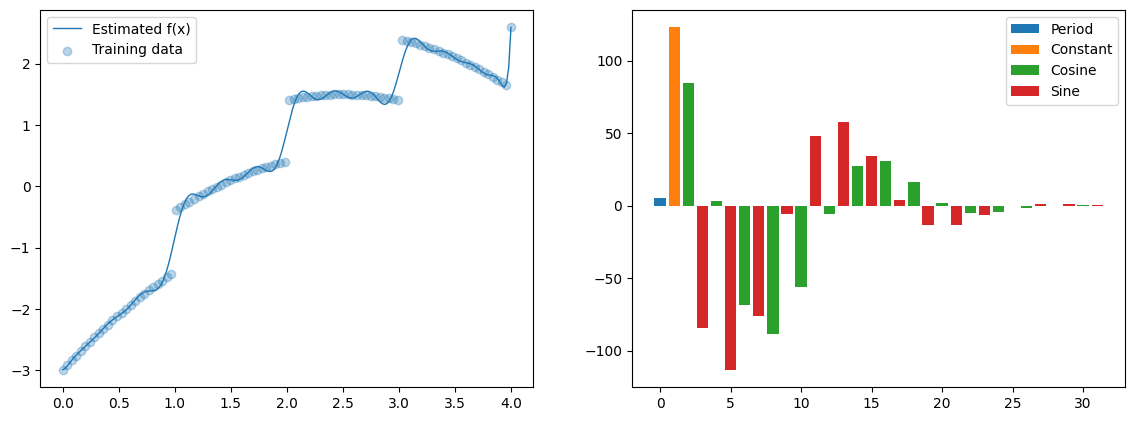

In [60]:
model_order = 15
n_data = 100

f = lambda x: -.4*x**2 + 2*x -3 + np.floor(x)

X = np.linspace(0, 4, n_data)
y = f(X)

loss = lambda theta: np.sum((y - fourier_series(X, theta))**2)
theta0 = np.random.uniform(0.1, 1, size=2+2*model_order)

theta0[0] = X.max() - X.min()

#bounds = [(-2, 2)]*len(theta0)
bounds = [(None, None)]*len(theta0)
bounds[0] = (2, 10)

res = minimize(loss, theta0, bounds=bounds, options={'disp': True})
theta = res.x
print("Started at %s, found minima at %s" % (theta0, theta))
print("Objective function value: %.3f" % res.fun)

fig = plt.figure(figsize=(14, 5), dpi=100)
ax = fig.subplots(1, 2)
ax[0].scatter(X, y, color='C0', alpha=.3, label="Training data")
X_plot = np.vstack(np.linspace(X.min(), X.max(), 200))
ax[0].plot(X_plot, fourier_series(X_plot, theta), color='C0', linewidth=1, label="Estimated f(x)")
ax[0].legend()

b = list(range(len(theta)))
ax[1].bar(b[0], theta[0], width=.8, color='C0', label="Period")
ax[1].bar(b[1], theta[1], width=.8, color='C1', label="Constant")
ax[1].bar(b[2], theta[2], width=.8, color='C2', label="Cosine")
ax[1].bar(b[3], theta[3], width=.8, color='C3', label="Sine")
for i in range(4, len(theta0)):
  if (i % 2) == 0:
    c = 'C2'
  else:
    c = 'C3'
  ax[1].bar(b[i], theta[i], width=.8, color=c)
#pos = np.arange((len(theta)-2)//2)*2+2
#l = tuple(["%i" % i for i in range(1, len(pos)+1)])
#assert len(pos)==len(l)
#ax[1].set_xticks(pos, l)
#ax[1].set_xlabel("[Hz]")
ax[1].legend()
fig.show()